## 5.2-5.4 Realistic Synthetic Spectra

In [1]:
import numpy as np
import pylab as plt
import utils

c = 299792458. # m/s
np.random.seed(42)
sqrttwopi = np.sqrt(2. * np.pi)

Generate the data:

In [2]:
fwhms = np.asarray([0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879]) # FWHM of Gaussian fit to line (A)
sigs = fwhms / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = np.asarray([4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87]) # line center (A)
cs = np.asarray([-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536]) # contrast (normalized flux)
ds = np.log(1. + cs) * sigs * sqrttwopi # trust us
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A
snr = 100.

N = 64
data, ivars, true_rvs = utils.make_data(N, xs, ds, ms, sigs, snr)

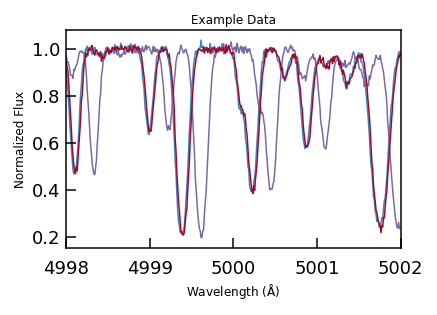

In [3]:
for n in range(0,N,30):
    plt.plot(xs, data[n])
plt.xlim([4998.,5002.])
plt.title('Example Data')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux')

Calculate CRLB:

In [4]:
crlb = utils.calc_crlb(xs, ds, ms, sigs, N, ivars)
print "CRLB:", crlb, "m/s"

('CRLB:', 11.073902947045001, 'm/s')


# 5.2 Binary mask x-correlation

Let's start by using the binary mask supplied in [the Ceres pipeline](https://github.com/rabrahm/ceres) ([Brahm et al. 2017](https://ui.adsabs.harvard.edu/#abs/2017PASP..129c4002B/abstract)), which claims to reproduce the capabilities of the (proprietary) HARPS instrument pipeline's binary mask. This should yield realistic results for a typical binary-mask-based data reduction.

In [21]:
guess_rvs = true_rvs + np.random.normal(0., 10., size=N) # first-guess RVs
rvs_0 = utils.binary_xcorr(guess_rvs, xs, data, ivars, dx, ms, harps_mask=True)

4998.005 5001.995
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge
quadratic_max: warning: grid edge


RV RMS: 207.360640295 m/s


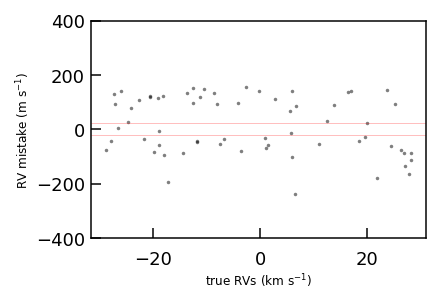

In [23]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)")
plt.ylabel(r"RV mistake (m s$^{-1}$)")
print "RV RMS:", np.std(resid), "m/s"

Not so great! Since we have full knowledge of the star & its spectrum, we can derive a best-case-scenario "perfect" binary mask. Let's see how that performs.